In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import pandas as pd
import scipy.stats
import math

In [90]:
from pyfasta import Fasta
import tqdm
import seaborn as sns

In [4]:
def getNames(fastafile):
    f = Fasta(fastafile)
    return f.keys()

In [6]:
def constructGroundTruth(truelist,seq_names):
    count_tsv={}
    for name in seq_names:
        count_tsv[name] = 0
    with open(truelist) as fp:
        lines = fp.readlines()
        for line in lines:
            tr = line.strip().split("/")[-1]
            count_tsv[tr] += 1
    return count_tsv

In [382]:
seq_names = getNames("/mnt/scratch7/hirak/bleed_through_7/reference/transcripts_all.fa")

In [256]:
def batchWriteTruth(types,prefix="/mnt/scratch1/bleed_through_human/poly_reads"):
    for t in tqdm.tqdm(types):
        truth_list = "/".join([prefix,t,"truth.list"])
        count_tsv = constructGroundTruth(truth_list, \
                                         seq_names)
        ground_df = pd.DataFrame(list(count_tsv.items()))
        ground_df.columns = ['transcript_id','count']
        ground_df.to_csv("/".join([prefix,"quant",t,"truth.tsv"]), \
                         sep="\t",index=False)

In [ ]:
#ground_df = pd.read_table("")

In [47]:
#ground_df.to_csv("/mnt/scratch1/bleed_through_human/poly_reads/quant/reads_101/truth.tsv",sep="\t",index=False)

In [969]:
##samplenames
all_types = []
import glob
fastq_files=glob.glob("/mnt/scratch7/hirak/bleed_through_7/subsets/poly_reads_salmon/*/*1.fasta.gz")
for f in fastq_files:
    dirname = f.split("/")[-2]
    all_types.append(dirname)

In [970]:
all_types

['reads_56', 'reads_33', 'reads_96', 'reads_199', 'reads_70']

In [974]:
batchWriteTruth(all_types,"/mnt/scratch7/hirak/bleed_through_7/subsets/poly_reads_salmon/")

100%|██████████| 5/5 [00:46<00:00,  9.38s/it]


In [961]:
def getMergedDataFrameSalmons(typeof,files):
    truth = pd.read_table(files[typeof]["truth"], delim_whitespace=True, \
       usecols=["transcript_id", "count"])
    df = truth
    df.rename(index=str, \
            columns={"transcript_id": "Name", "count": "count"}, inplace = True)
    
    sla = pd.read_table(files[typeof]["SLA"], delim_whitespace=True, \
                                 usecols=["Name", "NumReads"])
    df = pd.merge(df,sla, how="outer", on = "Name").fillna(0.0)
    
    
    #bowtie = pd.read_table(files[typeof]["bowtie"], delim_whitespace=True, \
     #                            usecols=["Name", "NumReads"])
    #bowtie.rename(index=str, columns = {"Name" : "Name", \
     #                                   "NumReads": "NumReads_BT"}, inplace = True)
    
    #df = pd.merge(df,bowtie, how="outer", on = "Name").fillna(0.0)
    
    kallisto = pd.read_table(files[typeof]["kallisto"], delim_whitespace=True, \
                                     usecols=["target_id", "est_counts"])
    kallisto.rename(index=str, columns={"target_id": "Name", \
                                                "est_counts": "NumReads_KAL"}, inplace = True)
    df = pd.merge(df,kallisto, how="outer", on = "Name").fillna(0.0)
    
    hera = pd.read_table(files[typeof]["hera"], delim_whitespace=True, \
                                     usecols=["#target_id", "est_counts"])
    hera["#target_id"]= hera["#target_id"].str.split(":",expand=True)[0]
    hera.rename(index=str, columns={"#target_id": "Name", \
                                               "est_counts": "NumReads_hera"}, inplace = True)
    
    df = pd.merge(df,hera, how="outer", on = "Name").fillna(0.0)
    
    
    #hera_mod = pd.read_table(files[typeof]["hera_mod"], delim_whitespace=True, \
    #                                 usecols=["#target_id", "est_counts"])
    #hera_mod["#target_id"]= hera_mod["#target_id"].str.split(":",expand=True)[0]
    #hera_mod.rename(index=str, columns={"#target_id": "Name", \
     #                                          "est_counts": "NumReads_hera_mod"}, inplace = True)
    
    #df = pd.merge(df,hera_mod, how="outer", on = "Name").fillna(0.0)
    return (df,truth,sla,kallisto,hera)

In [962]:
def getMergedDataFrameFast(typeof,files):
    truth = pd.read_table(files[typeof]["truth"], delim_whitespace=True, \
       usecols=["transcript_id", "count"])
    df = truth
    df.rename(index=str, \
            columns={"transcript_id": "Name", "count": "count"}, inplace = True)
    
    sla = pd.read_table(files[typeof]["SLA"], delim_whitespace=True, \
                                 usecols=["Name", "NumReads"])
    df = pd.merge(df,sla, how="outer", on = "Name").fillna(0.0)
    
    
    bowtie = pd.read_table(files[typeof]["bowtie"], delim_whitespace=True, \
                                 usecols=["Name", "NumReads"])
    bowtie.rename(index=str, columns = {"Name" : "Name", \
                                        "NumReads": "NumReads_BT"}, inplace = True)
    
    df = pd.merge(df,bowtie, how="outer", on = "Name").fillna(0.0)
    
    kallisto = pd.read_table(files[typeof]["kallisto"], delim_whitespace=True, \
                                     usecols=["target_id", "est_counts"])
    kallisto.rename(index=str, columns={"target_id": "Name", \
                                                "est_counts": "NumReads_KAL"}, inplace = True)
    df = pd.merge(df,kallisto, how="outer", on = "Name").fillna(0.0)
    
    hera = pd.read_table(files[typeof]["hera"], delim_whitespace=True, \
                                     usecols=["#target_id", "est_counts"])
    hera["#target_id"]= hera["#target_id"].str.split(":",expand=True)[0]
    hera.rename(index=str, columns={"#target_id": "Name", \
                                               "est_counts": "NumReads_hera"}, inplace = True)
    
    df = pd.merge(df,hera, how="outer", on = "Name").fillna(0.0)
    
    
    #hera_mod = pd.read_table(files[typeof]["hera_mod"], delim_whitespace=True, \
    #                                 usecols=["#target_id", "est_counts"])
    #hera_mod["#target_id"]= hera_mod["#target_id"].str.split(":",expand=True)[0]
    #hera_mod.rename(index=str, columns={"#target_id": "Name", \
     #                                          "est_counts": "NumReads_hera_mod"}, inplace = True)
    
    #df = pd.merge(df,hera_mod, how="outer", on = "Name").fillna(0.0)
    return (df,truth,sla,kallisto,hera)

In [963]:
def mergeHeraKallisto(typeof,files):
    
    #truth
    truth = pd.read_table(files[typeof]["truth"], delim_whitespace=True, \
       usecols=["transcript_id", "count"])
    df = truth
    df.rename(index=str, \
            columns={"transcript_id": "Name", "count": "count"}, inplace = True)
    
    #SLA
    sla = pd.read_table(files[typeof]["SLA"], delim_whitespace=True, \
                                 usecols=["Name", "NumReads"])
    df = pd.merge(df,sla, how="outer", on = "Name").fillna(0.0)
    
    #hera
    hera = pd.read_table(files[typeof]["hera"], delim_whitespace=True, \
                                     usecols=["#target_id", "est_counts"])
    hera["#target_id"]= hera["#target_id"].str.split(":",expand=True)[0]
    hera.rename(index=str, columns={"#target_id": "Name", \
                                               "est_counts": "NumReads_hera"}, inplace = True)
    df = pd.merge(df,hera, how="outer", on = "Name").fillna(0.0)
    
    #kallisto
    kallisto = pd.read_table(files[typeof]["kallisto"], delim_whitespace=True, \
                                     usecols=["target_id", "est_counts"])
    kallisto.rename(index=str, columns={"target_id": "Name", \
                                                "est_counts": "NumReads_KAL"}, inplace = True)
    df = pd.merge(df,kallisto, how="outer", on = "Name").fillna(0.0)
    
    return df

In [964]:
def relDiff(c1, c2, DF, cutoff=0.01, verbose=False):
    import pandas as pd
    """
    Computes the relative difference between the values
    in columns c1 and c2 of DF.
    c1 and c2 are column names and DF is a Pandas data frame.
    Values less than cutoff will be treated as 0.
    The relative difference is defined as
    d(x_i, y_i) =
        0.0 if x_i and y_i are 0
        (x_i - y_i) / (0.5 * |x_i - y_i|) otherwise
    This function returns two values.
    rd is a DataFrame where the "relDiff" column contains all
    of the computed relative differences.
    nz is a set of indexes into rd for data points where
    x_i and y_i were not *both* zero.
    """
    import numpy as np
    rd = pd.DataFrame(data = {"Name" : DF.index, "relDiff" : np.zeros(len(DF.index))*np.nan})
    rd.set_index("Name", inplace=True)
    bothZero = DF.loc[(DF[c1] <= cutoff) & (DF[c2] <= cutoff)].index
    nonZero = DF.index.difference(bothZero)
    if (verbose):
        print("Zero occurs in both columns {} times".format(len(rd.loc[bothZero])))
        print("Nonzero occurs in at least 1 column {} times".format(len(rd.loc[nonZero])))
    allRD = 1.0 * ((DF[c1] - DF[c2]) / (DF[c1] + DF[c2]).abs())
    assert(len(rd.loc[nonZero]["relDiff"]) == len(allRD[nonZero]))
    rd["relDiff"][nonZero] = allRD[nonZero]
    if len(bothZero) > 0:
        rd["relDiff"][bothZero] = 0.0
    return rd, nonZero

In [965]:
types_n = ["reads_101","reads_121","reads_114","reads_131","reads_120","reads_137"]

In [971]:
def prepareFileInfo(salmon_type):
    #prefix = "/mnt/scratch1/bleed_through_human/poly_reads/quant"
    prefix = "/mnt/scratch7/hirak/bleed_through_7/subsets/poly_reads_salmon/quant"
    #types = ["reads_101"]
    types = all_types
    #types = [ 'reads_85', 'reads_188', 'reads_141']
    files = {}
    for t in types:
        fileinfo = {}
        fileinfo["truth"]= "/".join([prefix,t,"truth.tsv"])
        #fileinfo["SLA"] =  "/".join([prefix,t,"salmon_out_noeff","quant.sf"])
        #fileinfo["SLA"] =  "/".join([prefix,t,"salmon_out","quant.sf"])
        fileinfo["SLA"] =  "/".join([prefix,t,"salmon_out",salmon_type,"quant.sf"])
        #fileinfo["SLA"] = "/home/rob/salmon_rescue_orphan/salmon/build/polyester_101/quant.sf"
        fileinfo["kallisto"] = "/".join([prefix,t,"kallisto_out","abundance.tsv"])
        #fileinfo["bowtie"] = "/".join([prefix,t,"bowtie_out",salmon_type,"quant.sf"])
        fileinfo["hera"] = "/".join([prefix,t,"hera_out","abundance.tsv"])
        #fileinfo["hera_mod"] = "/".join(["/home/rob/our_hera/hera-master",t,"abundance.tsv"])
        files[t] = fileinfo
    return files

In [972]:
def getDataframe(files):
    result_df = pd.DataFrame(columns=['sample','kallisto', 'SLA', 'hera'])
    #types = ["reads_101"]
    types = all_types
    #types = [ 'reads_85', 'reads_188', 'reads_141']
    for i,t in enumerate(types):
        #print(t)
        #df, truth, sla,kallisto,hera = getMergedDataFrameFast(t,files)
        #df, truth, sla,kallisto,hera = mergeHeraKallisto(t,files)
        df = mergeHeraKallisto(t,files)
        #print df.columns
        kal=df["count"].corr(df["NumReads_KAL"],method="spearman")
        sla=df["count"].corr(df["NumReads"],method="spearman")
        hera=df["count"].corr(df["NumReads_hera"],method="spearman")
        #kal=np.log(df["count"]+1).corr(np.log(df["NumReads_KAL"]+1),method="pearson")
        #sla=np.log(df["count"]+1).corr(np.log(df["NumReads"]+1),method="pearson")
        #hera=np.log(df["count"]+1).corr(np.log(df["NumReads_hera"]+1),method="pearson")
        
        #bt=df["count"].corr(df["NumReads_BT"],method="spearman")
        #hera_mod=df["count"].corr(df["NumReads_hera_mod"],method="spearman")
        result_df.loc[i] = [t,kal,sla,hera]
        #print("sample name: {}".format(t))
        #print("kallisto",df["count"].corr(df["NumReads_KAL"],method="spearman"))
        #print("SLA",df["count"].corr(df["NumReads"],method="spearman"))
        #print("BowTie2",df_30["count"].corr(df_30["NumReads_BT"],method="spearman"))
        #print("hera",df["count"].corr(df["NumReads_hera"],method="spearman"))
    return result_df

In [975]:
#result_df = pd.DataFrame(columns=['sample','kallisto', 'SLA', 'hera'])
salmon_types = ['no_option','no_eff']
#salmon_types = ['no_option']
result_dict = {}
for salmon_type in salmon_types:
    print(salmon_type)
    files = prepareFileInfo(salmon_type)
    #result_df.append(getDataframe(files),ignore_index=True)
    result_df = getDataframe(files)
    print result_df

no_option
      sample  kallisto       SLA      hera
0   reads_56  0.899018  0.925225  0.870006
1   reads_33  0.898364  0.924622  0.850446
2   reads_96  0.898037  0.924147  0.801252
3  reads_199  0.898622  0.923795  0.816789
4   reads_70  0.897556  0.925029  0.878071
no_eff
      sample  kallisto       SLA      hera
0   reads_56  0.899018  0.940185  0.870006
1   reads_33  0.898364  0.940213  0.850446
2   reads_96  0.898037  0.940204  0.801252
3  reads_199  0.898622  0.940375  0.816789
4   reads_70  0.897556  0.940983  0.878071


In [927]:
#result_df = pd.DataFrame(columns=['sample','kallisto', 'SLA', 'hera'])
salmon_types = ['no_option','no_eff']
#salmon_types = ['no_option']
result_dict = {}
for salmon_type in salmon_types:
    print(salmon_type)
    files = prepareFileInfo(salmon_type)
    #result_df.append(getDataframe(files),ignore_index=True)
    result_df = getDataframe(files)
    print result_df

no_option
     sample  kallisto       SLA      hera
0  reads_52  0.855514  0.889599  0.842389
1  reads_49  0.850211  0.887771  0.875235
2   reads_7  0.807171  0.840258  0.701791
no_eff
     sample  kallisto       SLA      hera
0  reads_52  0.855514  0.912096  0.842389
1  reads_49  0.850211  0.913035  0.875235
2   reads_7  0.807171  0.864966  0.701791


In [508]:
salmon_types = ['no_option']
for salmon_type in salmon_types:
    print(salmon_type)
    files = prepareFileInfo(salmon_type)
    #result_df.append(getDataframe(files),ignore_index=True)
    result_df = getDataframe(files)
    print result_df

no_option
      sample  kallisto       SLA      hera
0   reads_44  0.853658  0.886023  0.813214
1  reads_179  0.851528  0.883645  0.855343
2   reads_98  0.850943  0.883794  0.856524
3   reads_92  0.850995  0.884072  0.801731
4  reads_153  0.847678  0.914188  0.809491


In [577]:
salmon_types = ['no_option']
for salmon_type in salmon_types:
    print(salmon_type)
    files = prepareFileInfo(salmon_type)
    #result_df.append(getDataframe(files),ignore_index=True)
    result_df = getDataframe(files)
    print result_df

no_option
      sample  kallisto       SLA      hera
0   reads_44  0.853658  0.886023  0.813214
1  reads_179  0.851528  0.883645  0.855343
2   reads_98  0.850943  0.913969  0.856524
3   reads_92  0.850995  0.884072  0.801731
4  reads_153  0.847678  0.914188  0.809491


In [949]:
df_eff_length_salmon  = pd.read_table("/mnt/scratch7/hirak/bleed_through_7/exp_1_14/SRR5638585_salmon/quant.sf",
                                   usecols=['Name','EffectiveLength','Length','TPM'])
df_salmon_7_eff  = pd.read_table("/mnt/scratch7/hirak/bleed_through_7/exp_1_14/poly_reads_salmon/\
quant/reads_7/salmon_out/no_option/quant.sf",
                                   usecols=['Name','EffectiveLength','Length','TPM'])
df_salmon_7_no_eff  = pd.read_table("/mnt/scratch7/hirak/bleed_through_7/exp_1_14/poly_reads_salmon/\
quant/reads_7/salmon_out/no_eff/quant.sf",
                                   usecols=['Name','EffectiveLength','Length','TPM'])

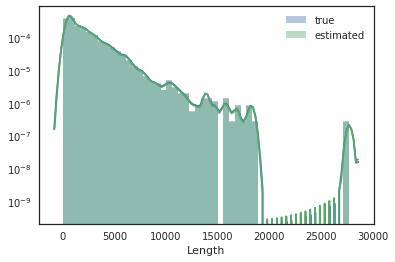

In [950]:

sns.distplot(df_salmon_7_no_eff.loc[df_salmon_7_no_eff['TPM'] > 0].Length, label = "true", hist_kws={'log':True})
sns.distplot(df_salmon_7_eff.loc[df_salmon_7_eff['TPM'] > 0].Length, label ="estimated", hist_kws={'log':True})

plt.legend()
#sns.distplot(df_salmon.loc[df_salmon['TPM'] > 0].EffectiveLength)

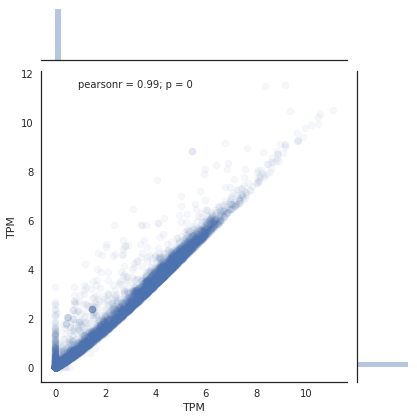

In [955]:
sns.jointplot(np.log(df_salmon_7_no_eff['TPM']+1),np.log(df_salmon_7_eff['TPM']+1), alpha=0.05 )

In [935]:
df_eff_length_salmon['Diff'] = df_eff_length_salmon.Length - df_eff_length_salmon.EffectiveLength

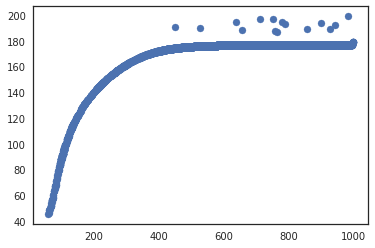

In [936]:
plt.scatter(df_eff_length_salmon.loc[(df_eff_length_salmon.TPM > 0.0) & \
                         (df_eff_length_salmon.Length < 1000)].Length,\
            df_eff_length_salmon.loc[(df_eff_length_salmon.TPM > 0.0) & \
                         (df_eff_length_salmon.Length < 1000)].Diff)

In [ ]:
# x1 = expressed trancript length in the subset True 
# x2 = estimated exprssed  

In [937]:
df_eff_length_salmon.loc[(df_eff_length_salmon.TPM > 0) & (df_eff_length_salmon.Length > 1000)]

,Name,Length,EffectiveLength,TPM,Diff
0,ENST00000502854.5,1480,1301.115,2.112073,178.885
1,ENST00000502634.1,1404,1225.115,30.029835,178.885
6,ENST00000521146.1,1258,1079.115,0.025214,178.885
8,ENST00000510163.5,2237,2058.115,17.490145,178.885
10,ENST00000355943.7,2385,2206.115,26.331339,178.885
11,ENST00000313368.7,2334,2155.115,78.590873,178.885
12,ENST00000350881.6,3222,3043.115,0.715278,178.885
13,ENST00000393792.2,3301,3122.115,18.865535,178.885
14,ENST00000274599.9,3268,3089.115,6.242604,178.885
16,ENST00000264930.9,5280,5101.115,0.010668,178.885


In [563]:
len(df_eff_length_salmon.loc[df_eff_length_salmon.Diff < 200.0])

8953

In [571]:
len(df_eff_length_salmon.loc[(df_eff_length_salmon.Diff > 246.0) &\
                             (df_eff_length_salmon.Diff < 250.0)])

186674

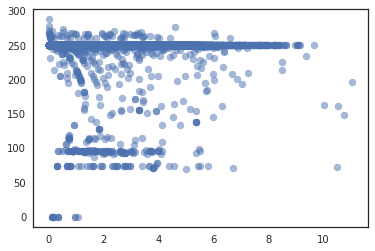

In [562]:
plt.scatter(np.log(df_eff_length_salmon.loc[df_eff_length_salmon.TPM > 0.0].TPM+1) ,\
            df_eff_length_salmon.loc[df_eff_length_salmon.TPM > 0.0].Diff,alpha=0.5)

In [543]:
df_eff_length_salmon.Diff.mean()

241.9730941661968

In [532]:
df_eff_length_salmon.loc[(df_eff_length_salmon.TPM == 0.0) & \
                         (df_eff_length_salmon.Length - df_eff_length_salmon.EffectiveLength > 0)].Length.mean()

1415.9532147773314

In [545]:
df_eff_length_cut = pd.read_table("/mnt/scratch7/hirak/bleed_through_7/poly_reads_salmon\
/quant/reads_98/salmon_out/eff_cut/quant.sf",
                                   usecols=['Name','EffectiveLength','Length','TPM'])
df_eff_length_cut['Diff'] = df_eff_length_cut.Length - df_eff_length_cut.EffectiveLength

In [546]:
df_eff_length_cut.Diff.mean()

235.9489271710221

In [398]:
fs = prepareFileInfo("no_option")

In [399]:
fd  = mergeHeraKallisto('reads_85',fs)

In [407]:
fd["count"].corr(fd["NumReads_KAL"],method="spearman")

0.8433905395026604

In [489]:
salmon_types = ['no_option','vb_opt','no_eff','no_eff_vb']
#salmon_types = ['no_option']
dataframe_dict = {}
for salmon_type in salmon_types:
    print(salmon_type)
    files = prepareFileInfo(salmon_type)
    #result_df.append(getDataframe(files),ignore_index=True)
    result_df = getDataframe(files)
    dataframe_dict[salmon_type] = result_df
    #print("kallisto\thera\tSLA\tBT")
    #print ("{0:.4f}\t{0:.4f}\t{0:.4f}\t{0:.4f}".format(result_df['kallisto'].mean(),\
    #                 result_df['hera'].mean(),result_df['SLA'].mean(),result_df['BT'].mean()))

no_option
vb_opt
no_eff
no_eff_vb


In [490]:
'''
for salmon_type in salmon_types:
    print salmon_type
    result_df = dataframe_dict[salmon_type]
    print("Agg\tkallisto\thera\tSLA\tBT")
    #print result_df
    print ("Mean\t{0:.4f}\t\t{1:.4f}\t{2:.4f}\t{3:.4f}".format(result_df['kallisto'].mean(),\
                     result_df['hera'].mean(),result_df['SLA'].mean(),result_df['BT'].mean()))
    print ("SE\t{0:.4f}\t\t{1:.4f}\t{2:.4f}\t{3:.4f}".format(result_df['kallisto'].sem(),\
                     result_df['hera'].sem(),result_df['SLA'].sem(),result_df['BT'].sem()))
    print ("Median\t{0:.4f}\t\t{1:.4f}\t{2:.4f}\t{3:.4f}".format(result_df['kallisto'].median(),\
                     result_df['hera'].median(),result_df['SLA'].median(),result_df['BT'].median()))
'''

'\nfor salmon_type in salmon_types:\n    print salmon_type\n    result_df = dataframe_dict[salmon_type]\n    print("Agg\tkallisto\thera\tSLA\tBT")\n    #print result_df\n    print ("Mean\t{0:.4f}\t\t{1:.4f}\t{2:.4f}\t{3:.4f}".format(result_df[\'kallisto\'].mean(),                     result_df[\'hera\'].mean(),result_df[\'SLA\'].mean(),result_df[\'BT\'].mean()))\n    print ("SE\t{0:.4f}\t\t{1:.4f}\t{2:.4f}\t{3:.4f}".format(result_df[\'kallisto\'].sem(),                     result_df[\'hera\'].sem(),result_df[\'SLA\'].sem(),result_df[\'BT\'].sem()))\n    print ("Median\t{0:.4f}\t\t{1:.4f}\t{2:.4f}\t{3:.4f}".format(result_df[\'kallisto\'].median(),                     result_df[\'hera\'].median(),result_df[\'SLA\'].median(),result_df[\'BT\'].median()))\n'

In [491]:
for salmon_type in salmon_types:
    print salmon_type
    result_df = dataframe_dict[salmon_type]
    print("Agg\tkallisto\thera\tSLA")
    #print result_df
    print ("Mean\t{0:.4f}\t\t{1:.4f}\t{2:.4f}".format(result_df['kallisto'].mean(),\
                     result_df['hera'].mean(),result_df['SLA'].mean()))
    print ("SE\t{0:.4f}\t\t{1:.4f}\t{2:.4f}".format(result_df['kallisto'].sem(),\
                     result_df['hera'].sem(),result_df['SLA'].sem()))
    print ("Median\t{0:.4f}\t\t{1:.4f}\t{2:.4f}".format(result_df['kallisto'].median(),\
                     result_df['hera'].median(),result_df['SLA'].median()))

no_option
Agg	kallisto	hera	SLA
Mean	0.8510		0.8273	0.8837
SE	0.0010		0.0119	0.0008
Median	0.8510		0.8132	0.8839
vb_opt
Agg	kallisto	hera	SLA
Mean	0.8510		0.8273	0.9035
SE	0.0010		0.0119	0.0004
Median	0.8510		0.8132	0.9034
no_eff
Agg	kallisto	hera	SLA
Mean	0.8510		0.8273	0.9143
SE	0.0010		0.0119	0.0006
Median	0.8510		0.8132	0.9143
no_eff_vb
Agg	kallisto	hera	SLA
Mean	0.8510		0.8273	0.9048
SE	0.0010		0.0119	0.0004
Median	0.8510		0.8132	0.9046


In [492]:
for salmon_type in salmon_types:
    print salmon_type
    result_df = dataframe_dict[salmon_type]
    #print("Agg\tkallisto\thera\tSLA\tBT")
    #print result_df
    print result_df.describe()

no_option
       kallisto       SLA      hera
count  5.000000  5.000000  5.000000
mean   0.850961  0.883745  0.827261
std    0.002144  0.001772  0.026504
min    0.847678  0.881043  0.801731
25%    0.850943  0.883793  0.809491
50%    0.850995  0.883919  0.813214
75%    0.851528  0.883946  0.855343
max    0.853658  0.886022  0.856524
vb_opt
       kallisto       SLA      hera
count  5.000000  5.000000  5.000000
mean   0.850961  0.903521  0.827261
std    0.002144  0.000951  0.026504
min    0.847678  0.902391  0.801731
25%    0.850943  0.902972  0.809491
50%    0.850995  0.903408  0.813214
75%    0.851528  0.903961  0.855343
max    0.853658  0.904874  0.856524
no_eff
       kallisto       SLA      hera
count  5.000000  5.000000  5.000000
mean   0.850961  0.914313  0.827261
std    0.002144  0.001325  0.026504
min    0.847678  0.912672  0.801731
25%    0.850943  0.913813  0.809491
50%    0.850995  0.914312  0.813214
75%    0.851528  0.914438  0.855343
max    0.853658  0.916330  0.856524
no_e

In [487]:
print("{0:.4f}".format(dataframe_dict['vb_opt']['hera'].mean()))

0.8387


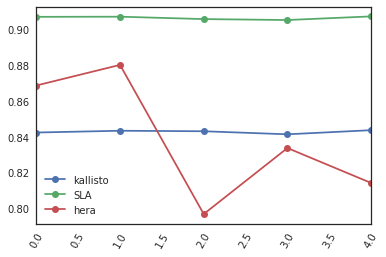

In [488]:
sns.set_style("white")
fig = plt.figure()
ax = fig.add_subplot(111)
result_df.plot(marker='o',rot=60,ax=ax)
#ax.set_xticks(result_df.index)

In [180]:
prefix = "/mnt/scratch1/bleed_through_human/poly_reads/quant"
#types = ["reads_101"]
files_rsem = {}
for t in types:
    fileinfo = {}
    #fileinfo["truth"]= "/mnt/scratch1/bleed_through_human/bleed_through_200K/rsem_exp/model.isoforms.results"
    fileinfo["truth"]= "/".join([prefix,t,"truth.tsv"])
    fileinfo["SLA"] =  "/".join([prefix,t,"salmon_out","quant.sf"])
    fileinfo["kallisto"] = "/".join([prefix,t,"kallisto_out","abundance.tsv"])
    #fileinfo["bowtie"] = "/".join([prefix,t,"quant","bowtie_out","quant.sf"])
    fileinfo["hera_mod"] = "/".join(["/home/rob/our_hera/hera-master",t,"abundance.tsv"])
    fileinfo["hera"] = "/".join([prefix,t,"hera_out","abundance.tsv"])
    files_rsem[t] = fileinfo

In [181]:
result_rsem_df = pd.DataFrame(columns=['sample','kallisto', 'SLA', 'hera','hera_mod'])
for i,t in enumerate(types):
    df, truth, sla,kallisto,hera = getMergedDataFrameFast(t,files_rsem)
    kal=df["count"].corr(df["NumReads_KAL"],method="spearman")
    sla=df["count"].corr(df["NumReads"],method="spearman")
    hera_mod=df["count"].corr(df["NumReads_hera_mod"],method="spearman")
    hera=df["count"].corr(df["NumReads_hera"],method="spearman")
    result_rsem_df.loc[i] = [t,kal,sla,hera,hera_mod]
    #print("sample name: {}".format(t))
    #print("kallisto",df["count"].corr(df["NumReads_KAL"],method="spearman"))
    #print("SLA",df["count"].corr(df["NumReads"],method="spearman"))
    #print("BowTie2",df_30["count"].corr(df_30["NumReads_BT"],method="spearman"))
    #print("hera",df["count"].corr(df["NumReads_hera"],method="spearman"))

In [888]:
df_eff_length_truth = pd.read_table("/mnt/scratch1/bleed_through_human/read_31415926/sim.sim.isoforms.results",
                                   usecols=['transcript_id','effective_length','count'])
df_eff_length_salmon = pd.read_table("/mnt/scratch1/bleed_through_human/read_31415926/quant/salmon_rsem_out/quant.sf",
                                   usecols=['Name','EffectiveLength','Length','TPM','NumReads'])
df_eff_length_hera = pd.read_table("/mnt/scratch1/bleed_through_human/read_31415926/quant/hera_out/abundance.tsv",
                                   usecols=['#target_id','eff_length','est_counts'])
df_eff_length_hera["#target_id"]= df_eff_length_hera["#target_id"].str.split(":",expand=True)[0]

df_eff_length_hera.set_index("#target_id",inplace=True)

df_eff_length_truth.set_index("transcript_id",inplace=True)
df_eff_length_salmon.set_index("Name",inplace=True)

In [889]:
df_eff = df_eff_length_truth.join(df_eff_length_salmon,how='right').fillna(0)
df_eff = df_eff.join(df_eff_length_hera,how='left')

In [890]:
len(df_eff_length_truth), len(df_eff_length_salmon),len(df_eff)

(21838, 146890, 146890)

In [891]:
df_tmp = df_eff.loc[(df_eff.Length < 1000) & (df_eff['count'] > 0)]

In [892]:
ind_48 = df_tmp.loc[(abs(df_tmp["eff_length"] -  df_tmp["EffectiveLength"]) > 0)].index

In [893]:
sum(df_eff['count'] > 0)

12451

In [894]:
#df_eff_length_truth.loc[df_eff_length_truth.index.isin(ind_48)]

In [895]:
df_eff['count'].corr(df_eff['NumReads'],method="spearman")

0.8206307054113883

In [896]:
laraib = df_eff.loc[np.abs(df_eff['effective_length'] - df_eff['EffectiveLength']) / np.abs(df_eff['effective_length'] + df_eff['EffectiveLength']) > 0.0, :]

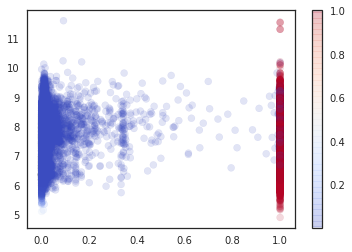

In [887]:
from matplotlib import cm
plt.scatter(np.abs(laraib['count'] - laraib['NumReads']) / (np.abs(laraib['count'] + laraib['NumReads'])), \
            np.log(laraib.Length), cmap=cm.coolwarm, c=np.abs(laraib['effective_length'] - laraib['EffectiveLength']) / np.abs(laraib['effective_length'] + laraib['EffectiveLength']),alpha=0.15)
plt.colorbar()

In [897]:
df_eff['count'].corr(df_eff['est_counts'],method="spearman")

0.8510439865595324

In [783]:
df_eff.loc[ind_48,'NumReads'] = df_eff.loc[ind_48,'count']

In [784]:
df_eff['count'].corr(df_eff['NumReads'],method="spearman")

0.8619939455324438

In [630]:
len(df_eff)

21838

(array([13.,  4., 12.,  5., 10.,  0.,  1.,  2.,  0.,  1.]),
 array([ 9.123594, 10.823594, 12.523594, 14.223594, 15.923594, 17.623594,
        19.323594, 21.023594, 22.723594, 24.423594, 26.123594]),
 <a list of 10 Patch objects>)

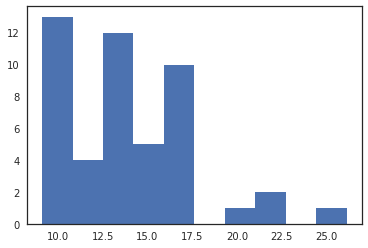

In [602]:
plt.hist(abs(df_tmp_2["eff_length"] -  df_tmp_2["EffectiveLength"]), bins = 10)

In [469]:
df_eff.head()

,effective_length,count,Length,EffectiveLength,TPM,eff_length
transcript_id,,,,,,
ENST00000001146.6,4550.63,0.0,4732,4550.713,0.000000,4549.836594
ENST00000003084.10,5950.63,2.0,6132,5950.713,0.030887,5949.836594
ENST00000004531.14,7378.63,2.0,7560,7378.713,0.006101,7377.836594
ENST00000004982.5,1275.63,19.0,1457,1275.713,1.368743,1274.836594
ENST00000005178.5,3394.63,1.0,3576,3394.713,0.027072,3393.836594


In [453]:
df_eff.loc[(df_eff['effective_length'] == 0) & (df_eff['TPM'] != 0)]

,effective_length,Length,EffectiveLength,TPM
transcript_id,,,,


In [470]:
df_eff_filt = df_eff.loc[df_eff['count'] > 0, :]

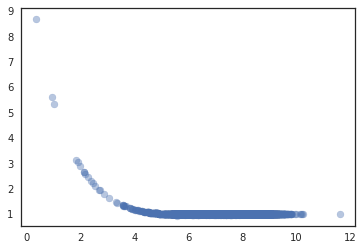

In [475]:
plt.scatter(np.log(df_eff_filt['effective_length']),df_eff_filt['EffectiveLength']/df_eff_filt['effective_length'],alpha=0.4)

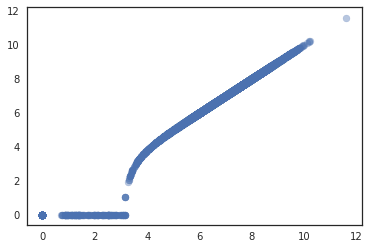

In [463]:
plt.scatter(np.log(df_eff['effective_length']+1),np.log(df_eff['eff_length']+1),alpha=0.4)

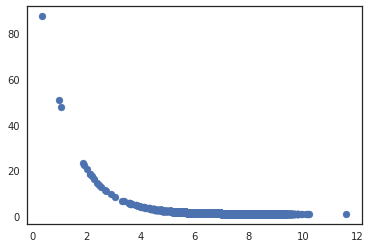

In [477]:
plt.scatter(np.log(df_eff_filt['effective_length']),df_eff_filt['Length']/df_eff_filt['effective_length'])

In [182]:
result_rsem_df.set_index(['sample'],inplace=True)

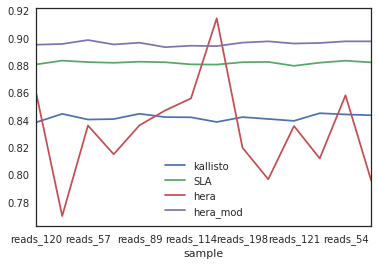

In [183]:
result_rsem_df.plot()

In [308]:
prefix = "/mnt/scratch1/bleed_through_human"
#types_of = ["read_31415926"]
#prefix = "/mnt/scratch6/hirak/SLA_benchmark/bleed_through_human/"
#types_of = ["read_11563" , "read_26368" , "read_9636"]
types_of = ["read_31415926"]
files_rsem = {}
for t in types_of:
    fileinfo = {}
    fileinfo["truth"]= "/".join([prefix , t,"sim.sim.isoforms.results"])
    fileinfo["SLA"] =  "/".join([prefix,t,"quant","salmon_out_noeff","quant.sf"])
    fileinfo["kallisto"] = "/".join([prefix,t,"quant","kallisto_out","abundance.tsv"])
    fileinfo["hera"] = "/".join([prefix,t,"quant","hera_out","abundance.tsv"])
    files_rsem[t] = fileinfo


In [309]:
result_rsem_df = pd.DataFrame(columns=['sample','kallisto', 'SLA','hera'])
for i,t in enumerate(types_of):
    df = mergeHeraKallisto(t,files_rsem)
    kal=df["count"].corr(df["NumReads_KAL"],method="spearman")
    sla=df["count"].corr(df["NumReads"],method="spearman")
    hera=df["count"].corr(df["NumReads_hera"],method="spearman")
    result_rsem_df.loc[i] = [t,kal,sla,hera]

In [307]:
result_rsem_df

,sample,kallisto,SLA,hera
0,read_31415926,0.749622,0.821377,0.822163


In [310]:
result_rsem_df

,sample,kallisto,SLA,hera
0,read_31415926,0.749622,0.861327,0.822163


In [241]:
rd,non_zeros = relDiff('count','NumReads_hera',df)
print rd.abs().mean()
rd,non_zeros = relDiff('count','NumReads',df)
print rd.abs().mean()
rd,non_zeros = relDiff('count','NumReads_KAL',df)
print rd.abs().mean()

relDiff    0.029856
dtype: float64
relDiff    0.031383
dtype: float64
relDiff    0.050081
dtype: float64


In [244]:
rd,non_zeros = relDiff('count','NumReads_hera',df)
print rd.abs().mean()[0]
rd,non_zeros = relDiff('count','NumReads',df)
print rd.abs().mean()
rd,non_zeros = relDiff('count','NumReads_KAL',df)
print rd.abs().mean()

0.02985572183733916
relDiff    0.031383
dtype: float64
relDiff    0.050081
dtype: float64


In [210]:
prefix = "/mnt/scratch1/bleed_through_human"
types = ["bleed_through_200K"]
files = {}
for t in types:
    fileinfo = {}
    fileinfo["truth"]= "/".join([prefix,t,"rsem_sim","sim.sim.isoforms.results"])
    fileinfo["SLA"] =  "/".join([prefix,t,"quant","salmon_out","quant.sf"])
    fileinfo["kallisto"] = "/".join([prefix,t,"quant","kallisto_out","abundance.tsv"])
    #fileinfo["bowtie"] = "/".join([prefix,t,"quant","bowtie_out","quant.sf"])
    #fileinfo["hera"] = "/".join([prefix,t,"quant","hera_out","abundance.tsv"])
    #fileinfo["hera"] = "/".join([prefix,"hera_new","abundance.tsv"])
    fileinfo["hera"] = "/".join([prefix,"hera_new_2","abundance.tsv"])
    files[t] = fileinfo

In [211]:
df = mergeHeraKallisto("bleed_through_200K",files)

In [212]:
print("kallisto",df["count"].corr(df["NumReads_KAL"],method="spearman"))
print("SLA",df["count"].corr(df["NumReads"],method="spearman"))
#print("BowTie2",df_30["count"].corr(df_30["NumReads_BT"],method="spearman"))
print("hera",df["count"].corr(df["NumReads_hera"],method="spearman"))

('kallisto', 0.7450557220439691)
('SLA', 0.8198710974237589)
('hera', 0.8193086327038834)
